In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab


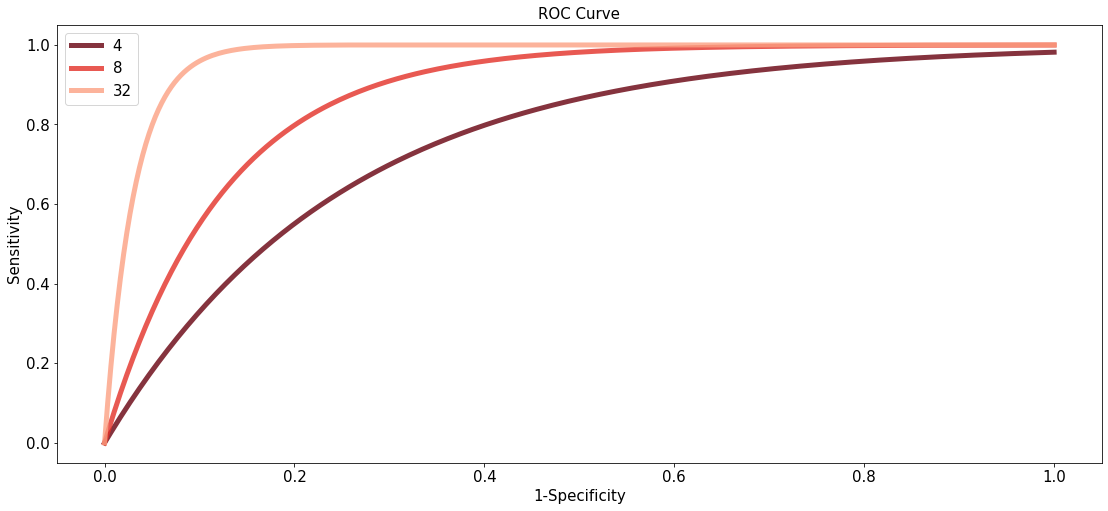

In [9]:
## A) Function for Age Invariant sensitivity  ######################################################################################
def plot_sens_spec_par(sens_spec_par=[4, 8, 32], palette="Blues_r", title="ROC Curve"):
    """
        Function assuming Age Invariant Sensitivity
        Plot ROC curves for different levels of sensibility-specificity par.
    """
    sens_spec_par = np.array(sens_spec_par)

    # Specificity Range
    test_spec = np.linspace(0, 1, 300)
    cm = pylab.get_cmap(palette)


    fig, ax = plt.subplots(1,1,figsize=(15.5, 7.2))
    for idx, sens in enumerate(sens_spec_par):


        NUM_COLORS = len(sens_spec_par)
        color = cm(1.*idx/NUM_COLORS)

        test_sens = 1-np.exp(-sens*(1-test_spec))
        ax.plot(1-test_spec, test_sens, linewidth=5, color=color, alpha=0.8, label=f'{sens}')

    ax.set_ylabel("Sensitivity", fontsize=15)
    ax.set_xlabel("1-Specificity", fontsize=15)
    ax.tick_params( which='both', axis='both', labelsize=15)
    ax.set_title(title, fontsize=15)
    ax.legend(fontsize=15)
    plt.tight_layout()


# example
plot_sens_spec_par(sens_spec_par=[4, 8, 32], palette="Reds_r")


In [10]:

#'Function to define infection over age
#'
#' @param ages a vector of integers defining all possible ages
#' @param par a vector of integers defining ages where infection occurs
#'
#'@return a vector of length 'ages' containing 1s where infection occurs, and 0s otherwise


def ages_infections_onehot(ages=np.arange(1, 60+1,1), ages_infections = np.arange(5, 7+1, 1)):
    """[summary]

    Args:
        ages ([type], optional): [description]. Defaults to np.arange(1, 60+1,1).
        ages_infections ([type], optional): [description]. Defaults to np.arange(5, 7+1, 1).

    Returns:
        [type]: [description]
    """
    return np.int32(np.isin(ages, ages_infections))

age_infection = ages_infections_onehot()



In [24]:

def compute_hazard_age(mu_b=0.3, mu_immunopath=0.2, mu_disease=0.2, mu_both=0.1, sensibility=0.7, specificity=0.8, ages_infections = np.arange(5, 7+1, 1), ages=np.arange(1, 60+1,1)):
    """[Return hazard over age]

    Args:
        mu_b (float, optional): [Baseline Mortality]. Defaults to 0.3.
        mu_immunopath (float, optional): [Mortality from Immunopathology]. Defaults to 0.2.
        mu_disease (float, optional): [Mortality from infection]. Defaults to 0.2.
        mu_both (float, optional): [Morality where both are occurring]. Defaults to 0.1.
        sensibility (float, optional): [Sensibility]. Defaults to 0.7.
        specificity (float, optional): [Specificity]. Defaults to 0.8.
        ages_infections ([type], optional): [Ages where infection occurs]. Defaults to np.arange(5, 7+1, 1).
        ages ([type], optional): [Ages range]. Defaults to np.arange(1, 60+1,1).
    """
    age_infection =  ages_infections_onehot(ages=ages, ages_infections=ages_infections)

    baseline = mu_b                                             # Baseline
    fp       = (1-specificity)*mu_immunopath*(1-age_infection)  # False Positive (not sick, think are)
    fn       = (1-sensibility)*mu_disease*age_infection         # False Negative (are sick, think not)
    tp       = sensibility*mu_both*age_infection                # True Positive (are sick, think are)

    hazard_age    = baseline + fp + fn + tp

    return hazard_age


In [25]:
#'Function to combine hazard and fertility to obtain the net reproductive rate (NRR)
#'
#' @param haz a vector of the mortality hazard over age
#' @param fert a vector of fertility over age
#'
#'@return a list containing Sx, survival over age; fert which is fert over age; and u which is the sum over age, i.e., the NRR.
#'

def compute_net_reproductive_rate(hazard, fertility):
    """[summary]

    Args:
        hazard ([type]): [Vector of the mortality hazard over age]
        feritility ([type]): [Vector of fertility over age]

    Returns:
        nrr ([type]): [Net reproductive rate]
        sur ([type]): [Survivorship]

    """
    # Cumulative Hazard
    cum_haz = np.cumsum(hazard)
    # Survivorship
    sur = np.exp(-cum_haz)
    # Net Reproductive Rate
    nrr = np.sum(sur*fertility)

    return (nrr, sur)

In [26]:
#'Wrapper for fitness; i.e., build NRR based on underlying parameters, including sensitivity and specificity
#'
#' @param par a named vector of parameters including sens (sensitivity), spec (specificity), mu_b (baseline mortality); mu_immunopath (mortality from immunopathology),
#'              mu_disease (mortality from the infection), and mu_both (mortality where both are occurring);
#' @param ageInfect - ages where infection occurs
#' @param ages - the full range of ages modeled
#' @param fert - a vector of fertility corresponding to each age in the vector ages
#'
#'@return a single value, the NRR.
#'
#    wrapFitness <- function(par=c(sens=0.7,spec=0.7,
#                            mu_b=0.1,mu_immunopath=0.02,
#                            mu_disease=0.2,mu_both=0.1),
#    			ageInfect=5:7,
#    			ages=1:60, fert=c(rep(0,15),rep(0.5,45))){
#    	#infect
#    	ageI <- ageInfection(par=ageInfect,ages=ages)
#    	#hazard age
#    	hzAge <- hazAge(infect=ageI,
#                            par=par)
#    	#NRR
#    	u <- NRR(hzAge,fert)
#    	return(u)
#    }

def wrap_fitness(fertility, mu_b=0.3, mu_immunopath=0.2, mu_disease=0.2, mu_both=0.1, sensibility=0.7, specificity=0.7, ages_infections = np.arange(5, 7+1, 1), ages=np.arange(1, 60+1,1)):
	"""[summary]

	Args:
		fertility ([type]): [Vector of fertilities for each age]
		60 ([type]): [description]
		1 ([type]): [description]
		mu_b (float, optional): [description]. Defaults to 0.3.
		mu_immunopath (float, optional): [description]. Defaults to 0.2.
		mu_disease (float, optional): [description]. Defaults to 0.2.
		mu_both (float, optional): [description]. Defaults to 0.1.
		sensibility (float, optional): [description]. Defaults to 0.7.
		specificity (float, optional): [description]. Defaults to 0.7.
		ages_infections ([type], optional): [description]. Defaults to np.arange(5, 7+1, 1).
		ages ([type], optional): [description]. Defaults to np.arange(1.

	Returns:
		[type]: [description]
	"""
	#infect
	age_infection1h = ages_infections_onehot(ages=ages, ages_infections=ages_infections)

	# hazard over ages
	hazard_age = hazard_age(mu_b=mu_b, mu_immunopath=mu_immunopath, mu_disease=mu_disease, mu_both=mu_both,
						sensibility=sensibility, specificity=specificity, ages_infections=age_infection1h, ages=ages)


	nrr = compute_net_reproductive_rate(hazard_age, fertility)

	return nrr

In [27]:
ages_infections = np.arange(5, 7+1, 1)
ages=np.arange(1, 60+1,1)
mu_immunopath=0.2
sensibility=0.7
specificity=0.7
mu_disease=0.2
mu_both=0.1
mu_b=0.3

fertility = [0]*15+[0.5]*45


In [33]:
age_infection1h = ages_infections_onehot(ages=ages, ages_infections=ages_infections)
# hazard over ages
hazard_age      = compute_hazard_age(mu_b=mu_b, mu_immunopath=mu_immunopath, mu_disease=mu_disease, mu_both=mu_both,
                    sensibility=sensibility, specificity=specificity, ages_infections=age_infection1h, ages=ages)

hazard_age

# Net Reproductive Rate
nrr, survivorship = compute_net_reproductive_rate(hazard_age, fertility)




0.004859157523686292

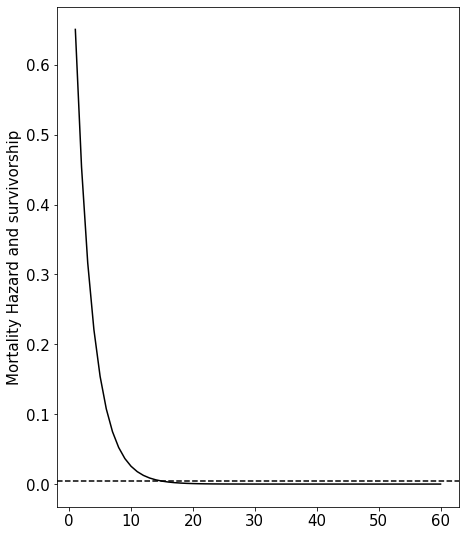

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(7.2, 9.2))

ax.plot(np.arange(1, 60+1), survivorship, color='k')
ax.axhline(y=nrr, color='k', linestyle='--')

ax.set_ylabel("Mortality Hazard and survivorship", fontsize=15)
ax.tick_params( which='both', axis='both', labelsize=15)



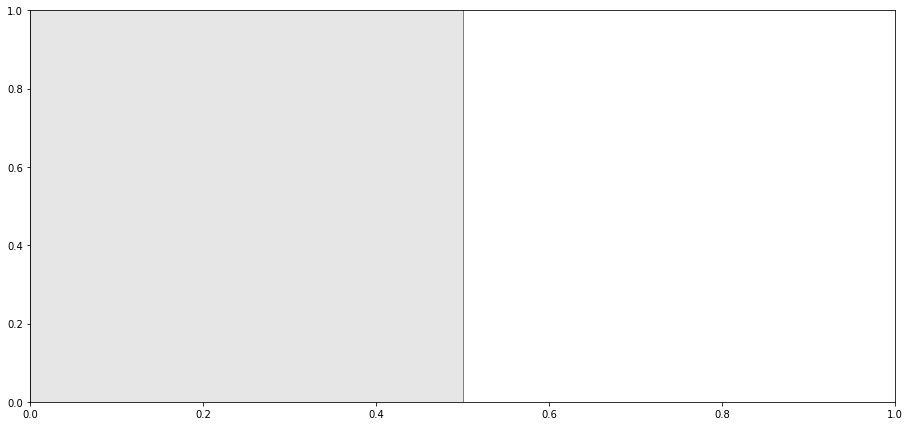

In [12]:
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import numpy as np

a = 0
b = 0.5

ix = np.linspace(a, b)
iy = 2*np.ones((ix.shape[0]))

fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2))
verts = [(a, 0), *zip(ix, iy), (b, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)

